   ## **PRACTICA PYTHON - CARLOS MERCADAL CARRETERO** 

##### En primer lugar importamos todas las librerías que vamos a utilizar a lo largo del código.

In [2]:
import itertools
import multiprocessing as mp
import pycodestyle
import plotly.graph_objects as go
import mplfinance as fplt
import matplotlib.dates as mdates
from datetime import timedelta
import statistics
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import utils
import funciones_multiprocessing



#### **Ejercicio 1 - TRADING CON BANDAS DE BOLLINGER**
En este ejercicio vamos a tratar de implementar un sistema de trading automático usando
las famosas bandas Bollinger.


**1) Utilizando la API de IEX vista en clase descarga los precios de cierre del ETF del índice SP500 con ticker SPY. Guarda los datos en un csv para no tener que realizar la descarga cada vez (recuerda que tienes un límite).**


En primer lugar preparo mi Token de IEX y establezco el activo que quiero descargarme en "Symbol" y el rango de datos que quiero en "range_url", en este caso 5 años. Posteriormente pongo la url base en una variable y preparo la url que utilizaré con un f-string. 

In [3]:
TOKEN = 'pk_864c90464ad84575999d4ba73ca53181'
symbol = "SPY"
range_url = '5y'
base_url = 'https://cloud.iexapis.com/stable'
url = f"{base_url}/stock/{symbol}/chart/{range_url}"

Realizo la petición a través de la url anterior con un "requests.get" y guardo los datos en la variable "data" en formato pandas. Seguidamente le establezco las fechas como índice y lo guardo en un CSV. De modo que a la hora de trabajar no tenga que hacer peticiones a la web de IEX de forma constante.

In [4]:
r = requests.get(url, params={'token': TOKEN, 'chartCloseOnly': True})
data = pd.read_json(r.content)
data = data.set_index("date")
data.to_csv("SP500.csv")

Cargamos el CSV parseando las fechas en la variable "spy" y nos quedamos con los precios de cierre en otra variable. En el momento de cargar el CSV, la línea que contiene la ruta tiene más de 79 carácteres, lo cual contradice las reglas PEP8; no obstante, considero que partir la ruta en dos partes no tiene sentido así que he optado por dejar la ruta entera en una línea. 

In [5]:
spy = pd.read_csv(
    r'C:\Users\Carlos\Documents\Master IA\PYTHON\practica_python\practica_python\SP500.csv',
    encoding="utf-8",
    parse_dates=True,
    index_col=0) 

# Seleccionamos los precios de cierre de la serie temporal
close_sp500 = spy['close']

**2) Calcula las bandas de Bollinger. Recuerda que las bandas Bollinger se calculan
como MA - K(std) y MA + K(std), donde MA es la media móvil de 30 muestras sobre el
precio, "std" es la desviación típica mçovil de 30 muestras sobre el precio y K = 2.**


Una vez tenemos la serie de precios de cierre, calculamos la media móvil de 30 días y la desviación típica. Posteriormente calculamos las banda superior e inferior conforme nos indica el enunciado.

In [6]:
mv_avg = close_sp500.rolling(30).mean()
std = close_sp500.rolling(30).std()
upper_band = mv_avg + (2 * std) 
lower_band = mv_avg - (2 * std)  

**3) Realiza una figura del apartado anterior.**

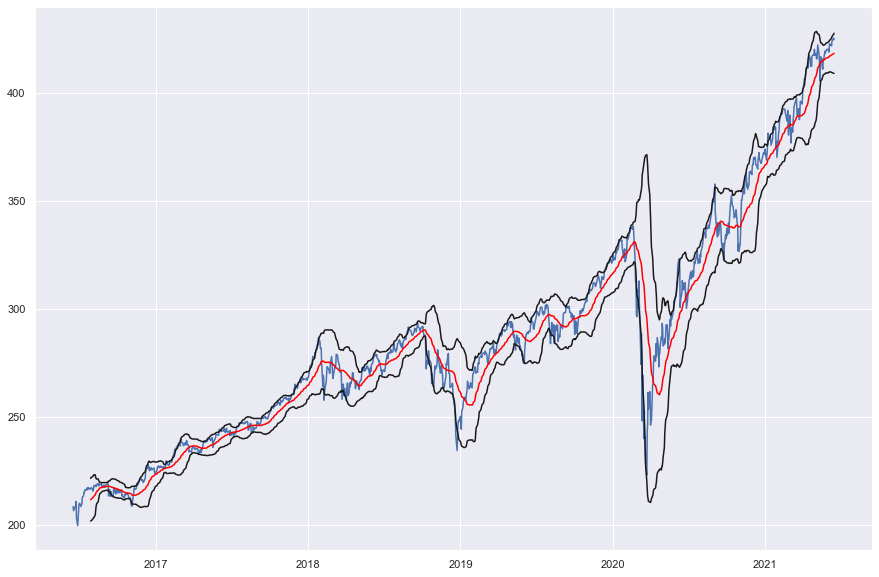

In [7]:
sns.set_theme()
plt.figure(figsize=(15,10))
plt.plot(close_sp500)
plt.plot(mv_avg, color='red')
plt.plot(upper_band, color='k')
plt.plot(lower_band, color="k")
plt.show()

**4) Usando las bandas Bollinger, calcula cuándo comprar y vender el activo. Compramos
cuando el precio del activo sale y vuelve a entrar en la banda inferior, y
vendemos cuando toca la banda superior. Por simplificación, solo operamos a largo y
si estamos comprados no podemos volver a comprar otra vez.**

Antes de empezar a realizar los cálculos, decido crear un data-frame con los datos calculados en el apartado anterior. Aplico un ".head" para ver qué pinta tiene.

In [8]:
df = pd.concat([close_sp500, upper_band, lower_band], axis=1)
df = pd.DataFrame(df)
df = df.set_axis(["close", "upper_band", "lower_band"], axis=1)
df = df.dropna()
df.head()

,close,upper_band,lower_band
date,,,
2016-07-28,216.7700,221.442920,201.718460
2016-07-29,217.1200,221.858445,201.886268
2016-08-01,216.9400,222.160191,202.279189
2016-08-02,215.5492,222.347318,202.605342
2016-08-03,216.1800,222.573325,202.895335


Genero una función a la cual le voy a pasar un único parámetro, que será el data-frame que he generado. La función va a iterar por las fechas de cierre y me va a guardar en una variable el precio de hoy, el precio de ayer, y el precio de ante ayer. Me va a hacer lo mismo con las bandas superiores e inferiores.

Una vez tengo esas variables definidas para cada día, simplemente me dedico a cumplir las condiciones de compra-venta establecidas en el enunciado. La principal consideración que he realizado es determinar que la compra se ejecute al día siguiente al de la señal de compra/venta. Es decir, si la señal de compra me la da al cierre del precio de ayer, entonces compro hoy. La razón de ser por la que he decidido hacerlo así es porque si me da la señal al cierre, lógicamente no puedo comprar hasta el día siguiente. 

In [9]:
def bandas_bollinger(df):
    '''Esta función sirve para calcular las bandas de bollinger,
    para ello debes pasarle un parámetro (data-frame).'''
    
    asset = 0
    buy = list()
    sell = list()

    for numero, date in enumerate(df.index):

        precio_hoy = df["close"][date]
        precio_ante_ayer = df["close"][numero - 2]
        banda_lower_ante_ayer = df["lower_band"][numero - 2]
        precio_ayer = df["close"][numero - 1]
        band_lower_ayer = df["lower_band"][numero - 1]
        band_upper_ayer = df["upper_band"][numero - 1]
        
        if numero == list(enumerate(df.index))[-1][0] and asset == 1:
            sell_signal = (date, precio_hoy)
            asset = 0
            sell.append(sell_signal)
        

        elif asset == 0:
            if precio_ante_ayer < banda_lower_ante_ayer and precio_ayer > band_lower_ayer:
                buy_signal = (date, precio_hoy)
                asset = 1
                buy.append(buy_signal)

        elif asset == 1:

            if precio_ayer >= band_upper_ayer:
                sell_signal = (date, precio_hoy)
                asset = 0
                sell.append(sell_signal)

    compras = pd.DataFrame(buy)
    ventas = pd.DataFrame(sell)
    result = pd.concat([compras, ventas], axis=1)
    result = result.set_axis(
        ['Fecha_C', 'Precio_C', 'Fecha_V', 'Precio_V'], axis=1)

    return(result)

Ejecuto la función:

In [10]:
result = bandas_bollinger(df)
result

,Fecha_C,Precio_C,Fecha_V,Precio_V
0,2016-09-13,213.23,2016-11-22,220.58
1,2017-04-18,233.87,2017-04-26,238.40
2,2018-02-12,265.34,2018-05-11,272.85
3,2018-10-17,280.45,2019-04-02,285.97
4,2019-05-15,285.06,2019-06-21,294.00
5,2019-08-08,293.62,2019-09-13,301.09
6,2020-03-03,300.24,2020-05-28,302.97
7,2020-09-25,328.73,2021-01-08,381.26


**5) Realiza una figura del apartado anterior. Intenta obtener algo parecido a la
Figura 1.**

Graficamos:

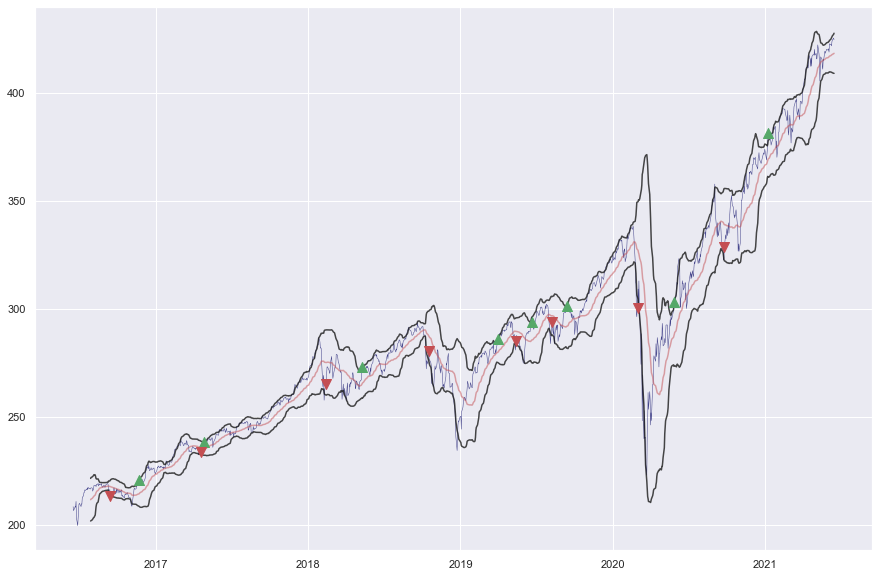

In [11]:
upper_band = pd.DataFrame(upper_band)
upper_band = upper_band.dropna()
lower_band = pd.DataFrame(lower_band)
lower_band = lower_band.dropna()
lower_band = lower_band.set_axis(["close"], axis=1)

sns.set_theme()
plt.figure(figsize=(15,10))
plt.plot(close_sp500, zorder=5, color="midnightblue", alpha=0.8, linewidth=0.5)
plt.plot(mv_avg, color='r', zorder=5, alpha=0.5)
plt.plot(upper_band, color='k', zorder=5, alpha=0.8)
plt.plot(lower_band, color="k", zorder=5, alpha=0.8)
plt.scatter(
    result.Fecha_V,
    result.Precio_V,
    marker="^",
    color="g",
    zorder=10,
    s=100)
plt.scatter(
    result.Fecha_C,
    result.Precio_C,
    marker="v",
    color="r",
    zorder=10,
    s=100)
plt.show()

**6) Calcula la rentabiliad media por operación:**

In [12]:
rentabilidad_media = (
    np.mean(result["Precio_V"] / result['Precio_C'] - 1)) * 100
print(round(rentabilidad_media,2),"%")

4.09 %


**7) Intenta optimizar los parámetros que quieras del cálculo de las bandas. ¿Qué
resultados obtienes?, ¿tiene sentido esta optimización?, ¿crees que los resultados son
realistas?. Si usas para esto la librería multiprocesing obtendrás puntuación extra.**

Para optimizar el cálculo de las bandas de bollinger he optado por utilizar la librería multiprocessing para una ejecución más rápida, importando una función desde el módulo "funciones_multiprocessing". En este caso genero dos listas, una en la que le pasaremos un rango de días y otra con un rango de números de desviaciones típicas respecto la media. A la función le vamos a pasar tres parámetros, que serán el 1) data-frame a utilizar, 2) el número de días para calcular la media móvil, y 3) el número de desviacions típicas respecto la media. La función se puede ver en el módulo adjunto. Debo indicar que como vamos a simular distintos escenarios, existe la posibilidad de que compremos y no vendamos nunca; para estos casos he establecido que si no ha vendido para el último día de la serie de precios, venda al último precio. 

Empezamos creando las listas mencionadas anteriormente:

In [13]:
dias = (np.arange(20, 100, 10)).tolist()
n_std = (np.arange(0,3,0.05)).tolist()
sp_list = [close_sp500]

Pasamos las listas que hemos creado por la librería "itertools" para poder procesarla con multiprocessing. También ponemos un contador de los núcleos que tenemos en nuestra CPU para poder trabajar con el máximo de potencia posible, dejando 2 nucleos libres para poder seguir usando el ordenador. En mi caso tengo 12 núcleos y lo proceso con 10. 

In [14]:
combinacion_bb = itertools.product(sp_list, dias, n_std)
pool = mp.Pool(mp.cpu_count()-2)

Debido a que el código lo he ejecutado en WINDOWS es necesario ejecutar la librería multiprocessing usando (if__name___=="__main__"). Una vez lo ejecutamos desde el main, le paso una primera función con pool.starmap que me va a generar una simulación de 480 escenarios, que me devolverá 480 data-frames cada uno con su media móvil y sus bandas de bollinger calculadas. Posteriormente le paso una segunda función con pool.starmap que va a calcular para cada uno de los escenarios, las operaciones de compra-venta que se ejecutarían en cada escenario. Ambas funciones están comentadas en el módulo funciones_multiprocessing.



In [15]:
if __name__ == "__main__":
    simulaciones = pool.starmap(
        funciones_multiprocessing.simulador_escenarios, combinacion_bb)
    rentabilidad_simulaciones = pool.starmap(
        funciones_multiprocessing.bb, simulaciones)

Las simulaciones devueltas consisten de una lista de tuplas, y en cada tupla aparecen 1) data-frame con la media y las bandas calculadas, 2) el número de días usada para la media móvil, 3) el número de desviaciones típicas usadas. Vemos qué pinta tienen las tres primeras simulaciones:

In [16]:
print(f"El numero de simulaciones realizadas es de: {len(simulaciones)}")
simulaciones[0:3]

El numero de simulaciones realizadas es de: 480


[(               close  upper_band  lower_band
  date                                        
  2016-07-14  216.1200  209.085575  209.085575
  2016-07-15  215.8300  209.458575  209.458575
  2016-07-18  216.4092  209.953035  209.953035
  2016-07-19  216.1900  210.370035  210.370035
  2016-07-20  217.0850  210.802285  210.802285
  ...              ...         ...         ...
  2021-06-09  421.6500  417.205500  417.205500
  2021-06-10  423.6100  418.115500  418.115500
  2021-06-11  424.3100  418.817000  418.817000
  2021-06-14  425.2600  419.251000  419.251000
  2021-06-15  424.4800  419.699000  419.699000
  
  [1239 rows x 3 columns],
  20,
  0.0),
 (               close  upper_band  lower_band
  date                                        
  2016-07-14  216.1200  209.293958  208.877192
  2016-07-15  215.8300  209.679878  209.237272
  2016-07-18  216.4092  210.184449  209.721621
  2016-07-19  216.1900  210.610100  210.129970
  2016-07-20  217.0850  211.052450  210.552120
  ...           

Ahora vemos los resultados de la segunda función, que nos ha calculado las rentabilidades de las compra-ventas de cada una de las simulaciones y nos devolverá una lista de tuplas como en el apartado anterior. En este caso en vez de un data-frame nos devuelve directamente la rentabildiad de cada simulación. Como hay algunas simulaciones en las que no se cumple ninguna condición y no se produce ninguna compra-venta, nos devuelve un None. Puesto que los "None" no nos interesan, los eliminamos. Una vez eliminados vemos qué pinta tienen los 10 primeros resultados.

Recordemos que el orden dentro de cada tupla es: 1) Rentabilidad, 2) Días, 3) Desviaciones típicas.

In [17]:
rentabilidad_simulaciones = list(
    filter(None.__ne__, rentabilidad_simulaciones))
rentabilidad_simulaciones[0:10]

[(1.2736335317594627, 20, 0.0),
 (0.7535339259781556, 20, 0.05),
 (1.0105401831243694, 20, 0.1),
 (1.1228544496217725, 20, 0.15000000000000002),
 (1.2075591993749857, 20, 0.2),
 (1.1918944268552203, 20, 0.25),
 (0.9107099820981861, 20, 0.30000000000000004),
 (1.0077111888654318, 20, 0.35000000000000003),
 (1.011716749901799, 20, 0.4),
 (0.9833133951686883, 20, 0.45)]

Para encontrar la mejor simulación de todas, debemos recorrer la lista de tuplas y buscar aquella que haya obtenido la mayor rentabilidad.

In [18]:
rentabilidad_previa = 0

for lista in np.arange(0, len(rentabilidad_simulaciones)):

    if rentabilidad_simulaciones[lista][0] > rentabilidad_previa:
        rentabilidad_previa = rentabilidad_simulaciones[lista][0]
        mejor_simulacion = rentabilidad_simulaciones[lista]

In [19]:
mejor_simulacion

(99.07142522159174, 20, 2.95)

Vamos a graficar la mejor simulación para ver qué pinta tiene:

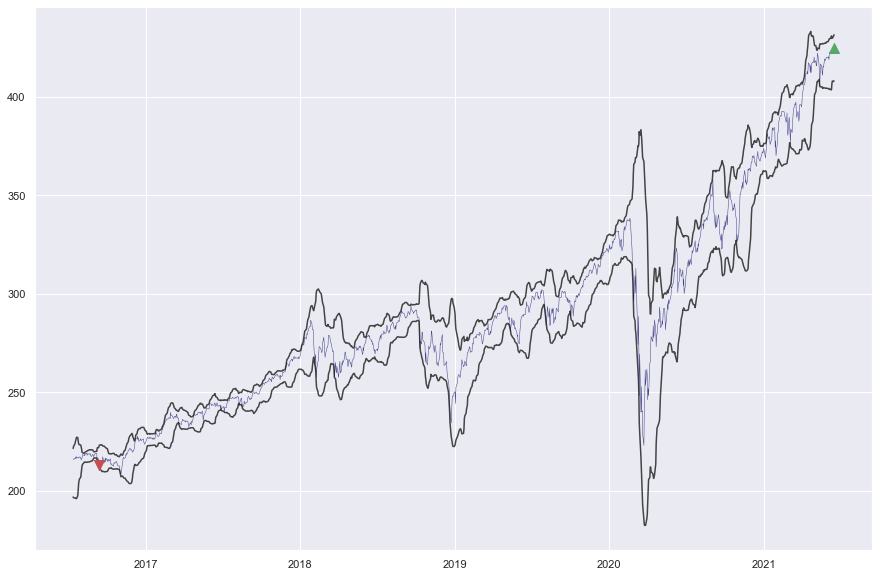

In [29]:
data = funciones_multiprocessing.simulador_escenarios(close_sp500, 20, 2.95)
resultado_simulacion = bandas_bollinger(data[0])

sns.set_theme()
plt.figure(figsize=(15,10))
plt.plot(data[0]['close'], zorder=5, color="midnightblue", alpha=0.8, linewidth=0.5)
plt.plot(data[0]['upper_band'], color='k', zorder=5, alpha=0.8)
plt.plot(data[0]['lower_band'], color="k", zorder=5, alpha=0.8)
plt.scatter(
    resultado_simulacion.Fecha_V,
    resultado_simulacion.Precio_V,
    marker="^",
    color="g",
    zorder=10,
    s=100)
plt.scatter(
    resultado_simulacion.Fecha_C,
    resultado_simulacion.Precio_C,
    marker="v",
    color="r",
    zorder=10,
    s=100)
plt.show()


Vemos que la simulación que nos ha generado una mayor rentabilidad dentro de los rangos que le hemos pasado, nos genera una rentabilidad del 99% usando una media móvil de 20 días y 2.95 desviaciones típicas respecto a la media. Claramente estamos ante un resultado nada realista, ya que es prácticamente imposible obtener esa rentabilidad.

Contestando a las preguntas planteadas, si partimos de la base de que "conocemos el futuro" como ocurre con nuestros datos, la optimización tiene sentido en tanto en cuanto que símplemente estamos intentando obtener la mayor rentabilidad posible jugando con los parámetros de la función. De este modo, estamos forzando a nuestra máquina a buscar aquella combinacion de medias móviles y desviaciones típicas que obtenga el mayor beneficio. En este sentido, podemos decir que estamos "moldeando" la realidad a nuestra medida. Si lleváramos esta práctica a la realidad, sería necesario invertir una cantidad monetaria X para cada una de las 480 estrategias, lo cual no parece que sea lo más óptimo, ya que en algunas ganarás dinero y en otras perderás, y no necesariamente tienes que obtener un resultado positivo.

Así mismo, añadir que el trading con bandas de bollinger tampoco sería la mejor opción porque no es más que un indicador de tendencia que no se debe utilizar como condición absoluta a la hora de invertir. Si se decide invertir siguiendo análisis de tendencias lo más sensato sería utilizar distintos indicadores, que en su conjunto, ayuden a crear una decisión de compra/venta más fundada. 

#### **Ejercicio 2 - MONTECARLO Y BOOTSTRAPPING**
En este ejercicio vamos a realizar una serie de proyecciones de los retornos que podemos
esperar, invirtiendo en el IBEX con dividendos durante un plazo de 5 años. El objetivo final
es obtener un análisis que diga al inversor las situaciones media, peor y mejor que se podrán
obtener al realizar la inversión.

Realizaremos estas proyecciones de dos maneras: Montecarlo simple y Bootstrapping
simple.
Los pasos serán los siguientes:


**1) Carga los datos de cierre del Ibex con dividendos que están en el fichero:
ibex div data close.csv.**

In [30]:
ibex = pd.read_csv(
    r'C:\Users\Carlos\Documents\Master IA\PYTHON\practica_python\practica_python\ibex_div_data_close.csv',
    encoding="utf-8",
    parse_dates=True,
    index_col=0)

ibex.head()

,close
2003-07-30,9755.3
2003-07-31,9755.3
2003-08-01,9785.1
2003-08-04,9714.6
2003-08-05,9779.3


**2) Calcula los retornos logarítmicos de la serie.**

In [31]:
retornos = np.log(ibex).diff().dropna()
retornos = retornos.set_axis(["close"], axis=1)
retornos

,close
2003-07-31,0.000000
2003-08-01,0.003050
2003-08-04,-0.007231
2003-08-05,0.006638
2003-08-06,-0.009628
...,...
2020-05-27,0.024064
2020-05-28,0.006895
2020-05-29,-0.017823
2020-06-01,0.017456


**3) Realiza una figura de la distribución de los retornos (puedes usar la función
distplot de seaborn). ¿Qué observas?.**


C:\Users\Carlos\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


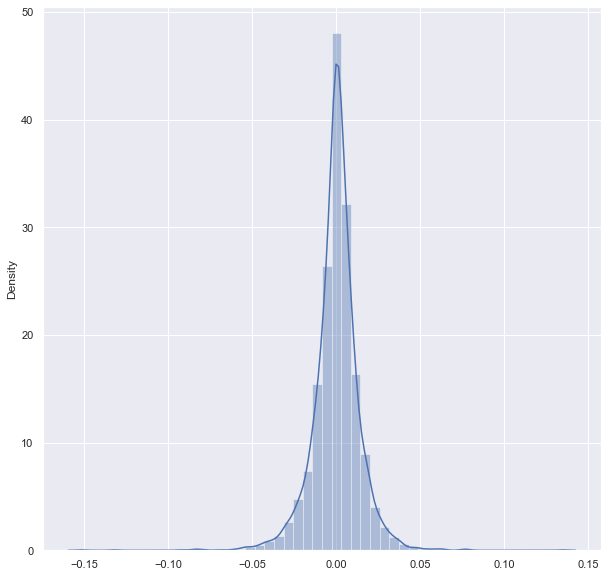

In [33]:
plt.figure(figsize=(10,10))
sns.distplot(retornos)
plt.show()

Viendo la distribución de los retornos logarítmicos vemos que genera una distribución leptocúrtica con una alta concentración de resultados en su media. Aún así observamos que existen ciertos outliers, los cuales tienen una probabilidad de ocurrencia más elevados que si fuera una distribución normal. Aun así, un inversor que tenga un perfil de aversión al riesgo alto, le interesará invertir en activos cuya distribución de sus retornos sea leptocúrtica, ya que maximiza las posibilidades de que su rentabilidad esté cerca de la media de retornos del activo. 

#### **Método I: SIMULACION DE MONTECARLO:**
**a) Calcula la media y la desviación típica de los retornos obtenidos en el apartado 2.**

In [34]:
pd.to_numeric(retornos["close"])
retornos_mean = statistics.mean(retornos["close"])
retornos_stdev = statistics.stdev(retornos["close"])
print("La media de los retornos es:", retornos_mean)
print("La desviación típica de los retornos es:", retornos_stdev)

La media de los retornos es: 0.00018723330377916808
La desviación típica de los retornos es: 0.013899086871962642


**b) Genera un dataframe con 1000 columnas, que serán cada una de las simulaciones
y donde las filas se extenderán un plazo de 5 años, desde el último de día de la
serie original. Los datos del dataframe se generan de forma aleatoria siguiendo una
distribución normal con la media y la desviación típica obtenida anteriormente.**

Para generar una simulación de Monte Carlo, primero vamos a crear un índice con el número de días que vamos a simular, en este caso durante un plazo de 5 años. Es importante tener en cuenta que sólo nos interesan los "business dates", por lo que los fines de semana y festivos no deben tenerse en cuenta. Esto lo solucionamos con el "freq=B". 

Para generar los datos de forma aleatoria siguiendo una distribución normal con media y desviación típica igual a la obtenida en el apartado anterior, usaremos la librería numpy con el método "random.normal" y pasándole como parámetros la media y desviación típica calculadas, y le indicamos el tamaño de 1000 simulaciones. Posteriormente creamos el índice con las fechas generadas anteriormente y mostramos la pinta que tiene la simulación.

In [35]:
IndiceMC = pd.date_range('2020-06-02', '2025-06-02', freq="B")

Monte_Carlo = pd.DataFrame(
    np.random.normal(
        retornos_mean,
        retornos_stdev,
        size=(
            len(IndiceMC),
            1000)))
Monte_Carlo = Monte_Carlo.set_index(IndiceMC)
Monte_Carlo

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2020-06-02,-0.001186,-0.001616,-0.021464,0.013354,0.006351,0.007811,-0.003053,0.022144,-0.007758,-0.024916,...,-0.002762,0.001507,0.002868,0.003234,0.010359,0.018886,-0.023632,0.005778,0.001822,-0.013386
2020-06-03,0.031739,-0.000720,0.022178,-0.013954,-0.005086,-0.002546,-0.008885,-0.005179,0.012568,0.006546,...,-0.004754,-0.000537,0.000657,-0.032018,-0.006384,0.007215,0.011175,-0.003046,-0.012921,-0.006116
2020-06-04,0.011350,0.007764,-0.008014,-0.008115,-0.000446,0.015133,0.003079,0.006188,-0.008620,-0.007660,...,-0.015850,0.013399,-0.013258,0.006416,-0.000778,-0.020744,-0.015047,0.033182,0.010879,0.007976
2020-06-05,-0.011154,-0.019222,0.000733,0.025408,-0.000707,-0.013963,-0.013572,0.025261,0.004622,0.006548,...,0.010815,-0.000519,0.016396,0.011821,0.013128,-0.020914,0.002795,-0.004979,-0.015501,0.021752
2020-06-08,-0.002425,-0.012635,-0.009271,-0.004159,0.014646,0.006499,0.002374,-0.010829,0.003663,0.027922,...,0.013509,0.001453,-0.039159,-0.031215,-0.000699,-0.010451,-0.003608,0.011021,-0.001166,-0.006131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-27,-0.008707,0.008602,0.032189,-0.000248,0.001819,-0.006420,-0.011139,-0.014006,-0.004369,0.008940,...,0.010175,-0.034770,0.004355,0.007715,-0.005289,-0.007992,0.013855,0.006870,-0.004746,-0.013174
2025-05-28,0.018586,-0.007517,-0.027281,-0.010025,0.005273,0.006562,0.010800,-0.001144,-0.001492,0.002135,...,0.021512,0.010597,-0.002488,-0.016241,0.018539,0.002156,0.010942,-0.004251,0.004907,0.024204
2025-05-29,-0.025978,0.012589,0.018485,-0.008087,0.006031,-0.016273,0.012849,0.004417,0.000199,0.010296,...,-0.002626,0.015913,-0.013230,-0.003028,-0.005896,-0.001727,-0.012506,-0.017697,0.000822,-0.009416
2025-05-30,0.011308,0.004625,-0.032215,-0.009918,0.013010,0.015008,-0.024203,0.006940,-0.010109,0.010327,...,-0.000756,-0.015553,0.002703,-0.014090,-0.008746,0.001697,-0.004122,0.002814,-0.025456,0.012204


#### **Método II: BOOTSTRAPPING:**
**a) En el Bootstrapping simple en vez de generar los retornos de forma aleatoria,
realizamos un muestreo aleatorio de los retornos de la serie original.**

**B) Genera el dataframe con las 1000 simulaciones, muestreando aleatoriamente con
remplazo los retornos de la serie original.**

Para el método Bootstrapping creamos un data-frame vacío para posteriormente rellenarlo con los datos aleatorios de la serie original. También creo una función que se va a encargar de realizar la simulación.

In [36]:
bootstrapping = pd.DataFrame(np.empty((len(IndiceMC), 1000), dtype=float))

In [37]:
def sim_bootstrap(df):
    '''Esta función sirve para generar una simulacion Bootstrapping. 
    Para ello es necesario pasarle un dataframe vacío que tenga por columnas 
    el número de simulaciones que querramos realizar.'''
    
    for columna in df.columns:
        aleatorio = retornos.sample(n=len(IndiceMC), replace=True).to_numpy()
        df[columna] = aleatorio

    df = df.set_index(IndiceMC)
    return(df)


Ejecutamos la función y vemos qué pinta tiene la simulación:

In [38]:
bootstrapping = sim_bootstrap(bootstrapping)
bootstrapping

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2020-06-02,0.018894,0.010618,0.001091,0.010824,0.006643,-0.003544,-0.003451,-0.000071,-0.002324,0.026342,...,-0.013514,0.002917,0.005117,0.009060,0.007781,0.019333,0.000868,0.002368,-0.012779,-0.030411
2020-06-03,-0.003130,0.000000,-0.012592,0.019241,-0.013777,0.002341,-0.002493,-0.001352,-0.035183,-0.001926,...,-0.033556,0.031567,0.001848,0.003958,0.015362,0.020028,0.003609,0.001057,0.000000,0.005324
2020-06-04,0.001069,-0.012922,0.006265,0.021953,0.008758,0.000091,0.033527,-0.001531,0.002049,-0.031457,...,0.014407,0.000000,0.013384,0.016632,-0.007051,-0.000947,-0.005340,0.000000,0.004663,0.003308
2020-06-05,-0.013146,-0.000760,0.001105,-0.003119,-0.004038,0.000000,0.004619,0.003982,0.003910,-0.001552,...,0.005159,0.000479,-0.009010,-0.006246,-0.013674,-0.035412,-0.004196,0.033509,0.031736,-0.000179
2020-06-08,0.008146,-0.007346,0.036118,0.007168,0.001212,-0.018287,0.014814,0.005655,0.009303,0.002767,...,0.032071,-0.012039,-0.006829,-0.002929,0.002942,-0.013655,-0.013848,-0.001168,0.002126,0.012929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-27,-0.000532,0.000535,-0.006503,0.005192,-0.014168,-0.017401,-0.014240,-0.004177,0.024105,-0.000167,...,0.002417,0.013192,-0.022042,0.014989,0.002473,-0.016175,0.019927,0.016460,0.001835,0.007478
2025-05-28,0.009732,0.017040,-0.000154,-0.036046,0.006579,-0.000861,0.004618,-0.034235,0.003851,0.008479,...,0.001479,0.001349,-0.022009,-0.000369,0.005627,-0.014373,0.003260,0.003035,0.006242,0.011262
2025-05-29,-0.014597,-0.000064,0.017241,0.018949,-0.009169,0.010879,-0.013460,0.000576,0.012580,0.001926,...,0.003751,-0.012107,0.008558,-0.002373,0.004744,0.012183,-0.003796,0.000125,-0.002792,0.007135
2025-05-30,0.004183,-0.005726,-0.016022,-0.004241,0.000530,-0.003130,0.004408,0.000000,-0.012305,0.007011,...,-0.001253,0.006239,0.000702,-0.019450,0.021291,-0.029780,0.007395,-0.003392,0.001212,-0.013500


**6) Para cada método, usando los retornos de una única simulación (una sola columna),
realiza una figura de la distribución de los retornos (puedes usar la función
distplot de seaborn). Compara la figura para cada método. ¿Qué concusiones puedes
extraer?.**

De acuerdo como nos indica el enunciado, generamos dos figuras de una única simulación para los dos métodos. He obtado por pasarle una simulación aleatoria para cada uno de los métodos.

C:\Users\Carlos\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Carlos\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


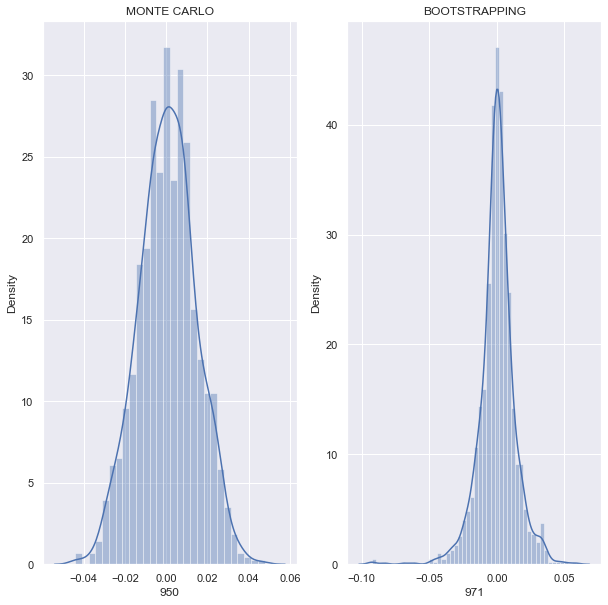

In [39]:
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
a = sns.distplot(Monte_Carlo[np.random.randint(0, 1000)], label="MONTE CARLO")
plt.title("MONTE CARLO")
plt.subplot(1, 2, 2)
b = sns.distplot(
    bootstrapping[np.random.randint(0, 1000)], label="BOOTSTRAPPING")
plt.title("BOOTSTRAPPING")
plt.show()


Analizando las distribuciones graficadas, vemos que prácticamente no existen diferencias entre ambos resultados. Si bien podemos ver alguna pequeña diferenciación en el dibujo, es evidente que ambas simulaciones están basadas en unos datos muy parecidos. Bootstrapping utiliza los datos de la serie original del Ibex, mientras que monte carlo, si bien no usa directamente esos retornos, se nutre de unos retornos aleatorios que siguen la misma distribución que la serie original, partiendo de su media y desviación típica. 



**7) Para cada método utilizando los retornos simulados, calcula la evolución temporal
de invertir una unidad monetaria en cada una de las simulaciones generadas.**

Puesto que hemos utilizado retornos logarítmicos, para calcular la evolución temporal de invertir una unidad monetaria vamos a usar la librería Numpy con su método "exp". 

In [40]:
bootstrap_compounding = np.exp(bootstrapping.cumsum())
montecarlo_compounding = np.exp(Monte_Carlo.cumsum())

In [41]:
bootstrap_compounding

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2020-06-02,1.019074,1.010675,1.001091,1.010883,1.006665,0.996462,0.996555,0.999929,0.997679,1.026692,...,0.986577,1.002921,1.005130,1.009102,1.007811,1.019521,1.000868,1.002370,0.987302,0.970047
2020-06-03,1.015889,1.010675,0.988564,1.030521,0.992891,0.998798,0.994073,0.998578,0.963188,1.024716,...,0.954020,1.035085,1.006989,1.013104,1.023413,1.040146,1.004487,1.003431,0.987302,0.975225
2020-06-04,1.016975,0.997699,0.994777,1.053394,1.001625,0.998889,1.027966,0.997051,0.965163,0.992983,...,0.967864,1.035085,1.020557,1.030095,1.016222,1.039161,0.999137,1.003431,0.991917,0.978456
2020-06-05,1.003694,0.996942,0.995877,1.050114,0.997589,0.998889,1.032726,1.001029,0.968944,0.991444,...,0.972871,1.035581,1.011402,1.023681,1.002421,1.003006,0.994954,1.037625,1.023901,0.978281
2020-06-08,1.011904,0.989645,1.032504,1.057669,0.998798,0.980789,1.048138,1.006705,0.978000,0.994191,...,1.004578,1.023188,1.004519,1.020687,1.005374,0.989402,0.981270,1.036413,1.026080,0.991011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-27,0.688583,1.439493,2.207188,1.695263,2.771890,1.196840,1.444355,0.749320,0.594864,1.287502,...,2.181147,1.770558,1.737015,1.102860,1.065848,1.120137,2.323103,1.432155,0.377313,1.120856
2025-05-28,0.695317,1.464233,2.206848,1.635244,2.790187,1.195810,1.451041,0.724101,0.597159,1.298465,...,2.184376,1.772948,1.699203,1.102453,1.071862,1.104153,2.330689,1.436508,0.379676,1.133550
2025-05-29,0.685241,1.464139,2.245226,1.666526,2.764721,1.208890,1.431641,0.724518,0.604718,1.300968,...,2.192585,1.751612,1.713808,1.099840,1.076960,1.117687,2.321859,1.436688,0.378617,1.141667
2025-05-30,0.688114,1.455780,2.209539,1.659473,2.766187,1.205112,1.437966,0.724518,0.597323,1.310121,...,2.189840,1.762574,1.715012,1.078655,1.100135,1.084893,2.339093,1.431823,0.379076,1.126358


In [42]:
montecarlo_compounding

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2020-06-02,0.998815,0.998385,0.978765,1.013444,1.006371,1.007842,0.996952,1.022391,0.992272,0.975391,...,0.997242,1.001508,1.002872,1.003239,1.010413,1.019065,0.976645,1.005795,1.001824,0.986704
2020-06-03,1.031025,0.997666,1.000714,0.999400,1.001266,1.005279,0.988133,1.017109,1.004821,0.981797,...,0.992513,1.000970,1.003530,0.971627,1.003982,1.026444,0.987620,1.002736,0.988963,0.980687
2020-06-04,1.042793,1.005442,0.992727,0.991322,1.000819,1.020608,0.991180,1.023423,0.996197,0.974305,...,0.976906,1.014473,0.990314,0.977880,1.003201,1.005371,0.972871,1.036566,0.999780,0.988540
2020-06-05,1.031227,0.986301,0.993455,1.016833,1.000111,1.006456,0.977819,1.049604,1.000812,0.980706,...,0.987528,1.013946,1.006685,0.989509,1.016458,0.984563,0.975594,1.031418,0.984401,1.010278
2020-06-08,1.028729,0.973917,0.984287,1.012612,1.014867,1.013018,0.980144,1.038300,1.004484,1.008475,...,1.000959,1.015420,0.968026,0.959098,1.015748,0.974327,0.972080,1.042848,0.983254,1.004104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-27,0.869798,1.411129,1.172965,0.887979,0.901732,0.784952,2.986624,0.432193,1.906588,1.160164,...,0.554739,0.940724,2.957709,1.423239,0.583083,0.941598,1.461420,1.128534,1.608150,0.756668
2025-05-28,0.886115,1.400561,1.141398,0.879122,0.906499,0.790120,3.019055,0.431698,1.903745,1.162643,...,0.566801,0.950746,2.950358,1.400311,0.593993,0.943630,1.477498,1.123746,1.616061,0.775206
2025-05-29,0.863392,1.418305,1.162693,0.872042,0.911983,0.777366,3.058099,0.433609,1.904124,1.174676,...,0.565315,0.965996,2.911582,1.396077,0.590502,0.942002,1.459136,1.104035,1.617389,0.767941
2025-05-30,0.873210,1.424880,1.125834,0.863435,0.923925,0.789120,2.984970,0.436629,1.884973,1.186869,...,0.564888,0.951088,2.919463,1.376544,0.585360,0.943602,1.453133,1.107145,1.576737,0.777370


**8) Para cada método utilizando el resultado del apartado anterior, obtén una figura
donde muestres 100 simulaciones. Deberás obtener una figura parecida a la Figura 2.**

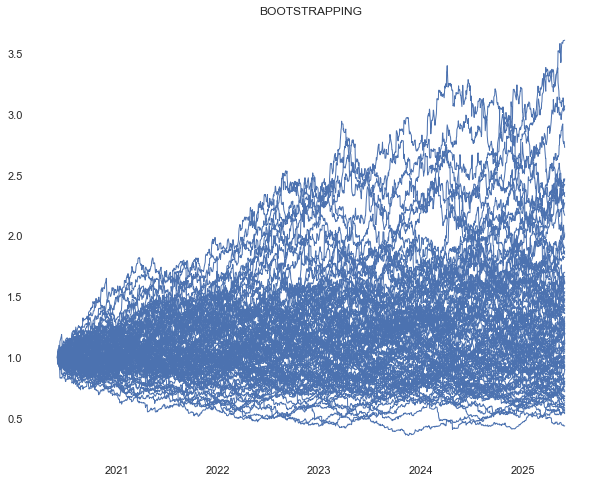

In [43]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
ax.set(facecolor='white')
plt.plot(bootstrap_compounding.sample(n=100, axis=1), color="b", linewidth=1)
plt.title("BOOTSTRAPPING")
plt.grid()
plt.show()



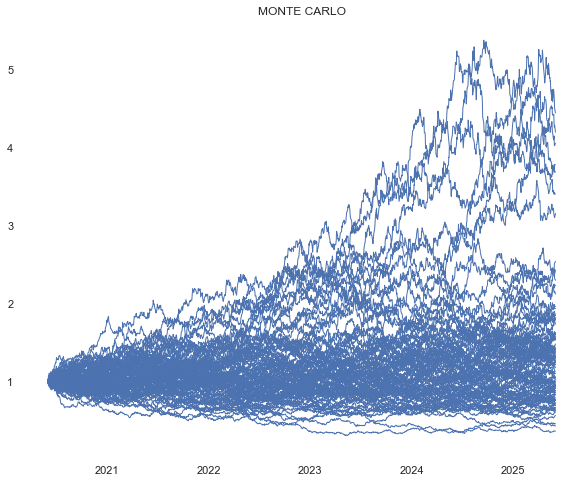

In [44]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
ax.set(facecolor='white')
plt.plot(montecarlo_compounding.sample(n=100, axis=1), color="b", linewidth=1)
plt.title("MONTE CARLO")
plt.show()

**9) Para cada método usando el dataframe de simulaciones, nos quedamos para cada
día con los retornos que ocupan los percentiles 0.05, 0.5 y 0.95.**

Generamos dos data-frames vacíos y los rellenaremos con los percentiles correspondientes para cada método. Me gustaría alcarar que, por lo que intepreto en el enunciado, debo coger las simulaciones originales de monte_carlo y bootstrapping, y NO las evoluciones monetarias para cada método (seguir leyendo en el apartado 10 para que tenga sentido).

In [45]:
percent_boot = pd.DataFrame(np.empty((len(IndiceMC), 3), dtype=float))
percent_boot = percent_boot.set_index(IndiceMC)
percent_boot.columns = ["0.05", "0.5", "0.95"]
percent_montecarlo = pd.DataFrame(np.empty((len(IndiceMC), 3), dtype=float))
percent_montecarlo = percent_montecarlo.set_index(IndiceMC)
percent_montecarlo.columns = ["0.05", "0.5", "0.95"]

Creo una función que me rellene los percentiles correspondientes para cada día. Le voy a pasar dos parámetros, el data-frame vacío a rellenar y la simulación correspondiente.

In [46]:
def percentiles(df_vacio, simulacion):
    '''Esta función se encargará de determinar los percentiles
    correspondientes para cada una de nuestras simulaciones.'''
    for fila in np.arange(0,len(df_vacio)):
        df_vacio.iloc[fila]['0.05'] = np.percentile(
            simulacion.iloc[fila, ], 5)
        df_vacio.iloc[fila]['0.5'] = np.percentile(
            simulacion.iloc[fila, ], 50)
        df_vacio.iloc[fila]['0.95'] = np.percentile(
            simulacion.iloc[fila, ], 95)
    return(df_vacio)
    

Ejecutamos la función y mostramos los retornos simulados que están en el percentil correspondiente para cada día para cada método.

In [47]:
percent_boot = percentiles(percent_boot, bootstrapping)
percent_boot

,0.05,0.5,0.95
2020-06-02,-0.019879,0.000170,0.020739
2020-06-03,-0.022354,0.000392,0.020017
2020-06-04,-0.019925,0.000264,0.022126
2020-06-05,-0.023249,0.000182,0.021686
2020-06-08,-0.019681,0.000527,0.022130
...,...,...,...
2025-05-27,-0.018381,0.000614,0.021005
2025-05-28,-0.022912,0.000201,0.021520
2025-05-29,-0.023263,0.000000,0.020863
2025-05-30,-0.021561,0.000773,0.019821


In [48]:
percent_montecarlo = percentiles(percent_montecarlo, Monte_Carlo)
percent_montecarlo

,0.05,0.5,0.95
2020-06-02,-0.023614,-0.000016,0.022961
2020-06-03,-0.024484,0.000052,0.023391
2020-06-04,-0.023347,-0.000122,0.022213
2020-06-05,-0.021355,0.000058,0.023594
2020-06-08,-0.021074,0.000574,0.023732
...,...,...,...
2025-05-27,-0.023483,-0.000976,0.021482
2025-05-28,-0.022574,0.000721,0.022370
2025-05-29,-0.022745,-0.000557,0.021563
2025-05-30,-0.023524,-0.001021,0.022528


**10) Para cada método utilizando el cálculo anterior, realiza una figura parecida a la
Figura 3.**

**Parte 1**

Siguiendo las indicaciones del apartado anterior, debería realizar una figura con la evolución monetaria de los data-frames con los percentiles generados anteriormente, para que me salga una figura parecida a la del enunciado de la práctica.

In [49]:
bootstrap_compounding = np.exp(percent_boot.cumsum())
montecarlo_compounding = np.exp(percent_montecarlo.cumsum())

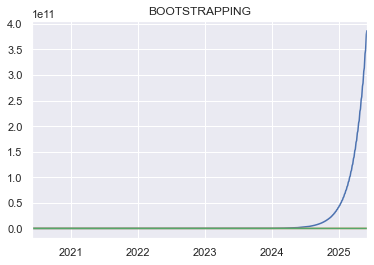

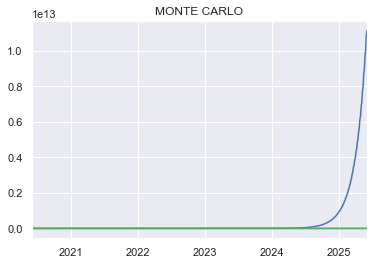

In [50]:
plt.plot(bootstrap_compounding['0.95'])
plt.plot(bootstrap_compounding['0.5'])
plt.plot(bootstrap_compounding['0.05'])
plt.title("BOOTSTRAPPING")
plt.margins(x=0)
plt.show()

plt.plot(montecarlo_compounding['0.95'])
plt.plot(montecarlo_compounding['0.5'])
plt.plot(montecarlo_compounding['0.05'])
plt.title("MONTE CARLO")
plt.margins(x=0)
plt.show()


De este modo, claramente si graficamos siguiendo los cálculos del apartado 9, no se parece en nada a la figura presentada en la práctica, ya que hay un crecimiento exponencial acumulado con el percentil 95. Así pues, me limito a contestar lo que me piden en la pregunta siguiendo una interpretación literal de la misma. 

**Parte 2**

Como lo que hemos hecho en la parte 1 no tiene mucho sentido, ya que no se parece en nada el resultado a la figura que debemos obtener. Voy a hacer una interpretación subjetiva, de modo que entiendo que el objetivo es obtener la figura 3. Para ello, no deberíamos partir del resultado del ejercicio 9 tal y como nos lo piden, si no mas bien realizar el cálculo del ejercicio 9 basándonos NO en el dataframe de las simulaciones originales, si no calculando los percentiles del dataframe de las evoluciones monetarias para cada método. Así pues:

Calculo la evolución monetaria y luego los percentiles:

In [51]:
bootstrap_compounding = np.exp(bootstrapping.cumsum())
montecarlo_compounding = np.exp(Monte_Carlo.cumsum())

In [52]:
percent_boot = percentiles(percent_boot, bootstrap_compounding)
percent_montecarlo = percentiles(percent_montecarlo, montecarlo_compounding)

Grafico para obtener la figura que nos han pedido:

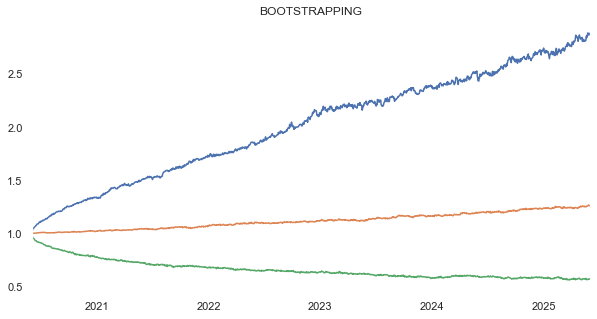

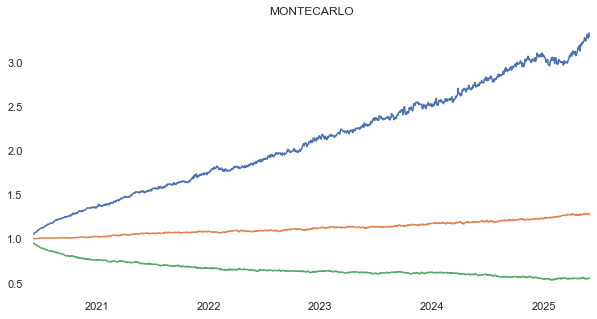

In [53]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
ax.set(facecolor='white')
plt.plot(percent_boot['0.95'])
plt.plot(percent_boot['0.5'])
plt.plot(percent_boot['0.05'])
plt.margins(x=0)
plt.title("BOOTSTRAPPING")
plt.show()

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
ax.set(facecolor='white')
plt.plot(percent_montecarlo['0.95'])
plt.plot(percent_montecarlo['0.5'])
plt.plot(percent_montecarlo['0.05'])
plt.margins(x=0)
plt.title("MONTECARLO")
plt.show()


De esta forma sí obtengo la figura que me han pedido, y no tengo el problema que me pasaba en la parte 1. No sé si es un tema de interpretación. En cualquier caso, dejo ambas posibilidades puesto que genera confusión.

**11) Realiza una comparación de los dos métodos y extrae unas conclusiones, ¿cuál
crees que es el mejor?.**

Viendo los resultados arrojados por ambos métodos, veo que realmente no existe una gran diferencia entre ambos métodos. Bootstrapping se ha dedicado a coger datos de la muestra original de precios y guardarlos de forma aleatoria, mientras que monte carlo ha cogido la media y desviación típica de esos datos y los ha generado de forma aleatoria. Al fin y al cabo, ambos están basándose en datos parecidos, la diferencia es que uno los genera y el otro los coge directametne de una serie de datos. De este modo, si bien las distribuciones presentaban alguna diferencia, cuando analizamos la evolución monetaria de forma temporal, vemos que los resultados son prácticamente idénticos, aunque aún así presentan diferencias. En mi opinión (totalmente infundada), podría ser que monte carlo fuera mejor en el sentido de que le da un componente de aleatoriedad en la generación de los datos, mientras que bootstrapping coge datos ya existentes. Del mismo modo que las rentabilidades pasadas no garantizan rentabilidades futuras, los datos del pasado no pueden ser idénticos a los datos del futuro, aunque sí pueden seguir una distribución parecida, y ahí puede que monte carlo tenga cierta ventaja.

#### **Ejercicio 3 - TRATAMIENTO DE SERIES FINANCIERAS**
En este ejercicio vamos a practicar el tratamiento de series temporales financieras. Para
ello usaremos datos tick a tick de un ETF del IVE (S&P 500 Value Index).
Calcularemos muestreos sobre estos datos tick a tick que son muy comunes en finanzas,
en concreto desarrollaremos las llamadas ticks bars y dollar bars. Si estas interesado en
conocer más detalles sobre esto puedes consultar [2].
Los datos los obtendremos de http://www.kibot.com/free_historical_data.aspx,
disponibles en el apartado \free tick intraday data" subapartado IVE: \Tick with bid ask
data".
Realiza los siguientes apartados:

**1) Carga los datos en pandas (el formato de los datos lo puedes ver en http:
//www.kibot.com/support.aspx#data_format) y pon todas las columnas en el tipo
correspondiente. Dado que el fichero de datos es muy grande, trabaja solo una parte
del mismo.**

Cargo los datos solicitados:

In [54]:
tickatick = pd.read_csv(
    r'C:\Users\Carlos\Documents\Master IA\PYTHON\practica_python\practica_python\IVE_tickbidask.txt',
    encoding="utf-8", parse_dates=True, header=None)
tickatick = tickatick.set_index(tickatick[0] + ' ' + tickatick[1])
tickatick.index = pd.to_datetime(tickatick.index)
del tickatick[0]
del tickatick[1]
tickatick = tickatick.set_axis(["price", "bid", "ask", "size"], axis=1)
tickatick[["price", "bid", "ask", "size"]] = tickatick[[
    "price", "bid", "ask", "size"]].apply(pd.to_numeric)


Por comodidad, voy a trabajar sobre 1 millón de datos. Entiendo que no es necesario que ejecute mi código sobre todo el archivo. 

In [55]:
df_etf = tickatick.head(1000000)
df_etf

,price,bid,ask,size
2009-09-28 09:30:00,50.79,50.70,50.79,100
2009-09-28 09:30:00,50.71,50.70,50.79,638
2009-09-28 09:31:32,50.75,50.75,50.76,100
2009-09-28 09:31:32,50.75,50.75,50.76,100
2009-09-28 09:31:33,50.75,50.75,50.76,100
...,...,...,...,...
2011-09-29 15:23:57,52.15,52.15,52.16,400
2011-09-29 15:23:57,52.15,52.15,52.16,400
2011-09-29 15:24:01,52.16,52.15,52.16,400
2011-09-29 15:24:01,52.16,52.15,52.16,100


**2) Calcula las velas (open, high, low, close, vol) horarias, diarias, mensuales y
anuales.**

Calculo las velas solicitadas:

In [56]:
velas_horarias_ohlcv = df_etf.resample("H").agg(
    {'price': 'ohlc', 'size': 'sum'}).dropna()
velas_horarias_ohlcv = velas_horarias_ohlcv.set_axis(
    ['open', 'high', 'low', 'close', 'volume'], axis=1)
velas_horarias_ohlcv

,open,high,low,close,volume
2009-09-28 09:00:00,50.7900,51.1500,50.7100,51.1200,89360
2009-09-28 10:00:00,51.1500,51.3800,51.1500,51.2900,167303
2009-09-28 11:00:00,51.2891,51.4400,51.2891,51.4073,137408
2009-09-28 12:00:00,51.4100,51.5100,51.4100,51.4180,40761
2009-09-28 13:00:00,51.4200,51.6000,51.4104,51.4800,65937
...,...,...,...,...,...
2011-09-29 11:00:00,52.7400,52.9949,52.6200,52.9300,31930
2011-09-29 12:00:00,52.9300,53.0200,52.6400,52.7700,48319
2011-09-29 13:00:00,52.7500,52.9200,52.3000,52.5600,56897
2011-09-29 14:00:00,52.4900,52.5052,51.9940,52.2200,75668


In [57]:
velas_diarias_ohlcv = df_etf.resample("D").agg(
    {'price': 'ohlc', 'size': 'sum'}).dropna()
velas_diarias_ohlcv = velas_diarias_ohlcv.set_axis(
    ['open', 'high', 'low', 'close', 'volume'], axis=1)
velas_diarias_ohlcv

,open,high,low,close,volume
2009-09-28,50.79,51.6000,50.7100,51.5400,810911
2009-09-29,51.78,51.9600,51.3700,51.4900,467547
2009-09-30,51.66,51.6900,50.7800,51.2900,454623
2009-10-01,51.16,51.1600,49.7800,50.3166,861723
2009-10-02,49.30,49.8100,49.1900,49.5100,874909
...,...,...,...,...,...
2011-09-23,51.00,51.7900,50.8300,51.5200,493034
2011-09-26,51.72,52.7100,51.1310,52.6600,417421
2011-09-27,53.86,54.1874,52.8800,53.2000,495186
2011-09-28,53.19,53.6180,51.9834,52.0600,362200


In [58]:
velas_mensuales_ohlcv = df_etf.resample("M").agg(
    {'price': 'ohlc', 'size': 'sum'}).dropna()
velas_mensuales_ohlcv = velas_mensuales_ohlcv.set_axis(
    ['open', 'high', 'low', 'close', 'volume'], axis=1)
velas_mensuales_ohlcv

,open,high,low,close,volume
2009-09-30,50.79,51.9600,50.7100,51.2900,1733081
2009-10-31,51.16,53.0822,49.1800,49.3602,11602304
2009-11-30,49.63,53.2100,48.9300,52.4400,9669746
2009-12-31,52.87,53.9600,52.2700,53.0100,9522785
2010-01-31,53.55,55.1790,51.8400,51.8900,8547593
2010-02-28,52.51,53.6400,50.2410,53.2600,8491466
2010-03-31,53.54,57.1100,53.5000,56.4600,8465282
2010-04-30,56.91,59.1000,56.6100,57.5600,10070612
2010-05-31,57.87,58.4700,0.1100,53.0400,18482556
2010-06-30,52.61,54.7600,49.5523,49.6966,10450407


In [59]:
velas_anuales_ohlcv = df_etf.resample("Y").agg(
    {'price': 'ohlc', 'size': 'sum'}).dropna()
velas_anuales_ohlcv = velas_anuales_ohlcv.set_axis(
    ['open', 'high', 'low', 'close', 'volume'], axis=1)
velas_anuales_ohlcv

,open,high,low,close,volume
2009-12-31,50.79,53.96,48.93,53.01,32527916
2010-12-31,53.55,59.87,0.11,59.59,138882636
2011-12-31,60.02,65.26,50.42,52.15,107852071


**3) Haz un gráfico de velas para cada apartado anterior. Puedes encontrar la función
plot candle para hacerlo en el módulo utils.py adjunto a esta práctica (es la misma
que usamos en clase).**

No tengo muy claro si es obligatorio usar utils, ni si es obligatorio pintar el volumen... por lo que propongo dos alternativas: 

**Alternativa 1 - Usando Utils**

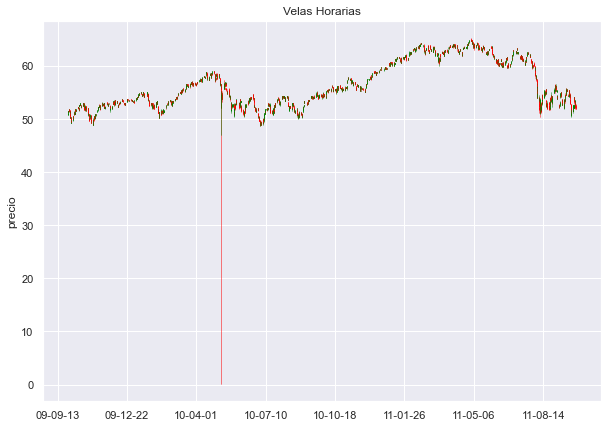

In [62]:
utils.plot_candle(velas_horarias_ohlcv,
                  width=.01,
                  figsize=(10, 7),
                  tick_formater='%y-%m-%d')

plt.title("Velas Horarias")
plt.ylabel('precio')
plt.show()

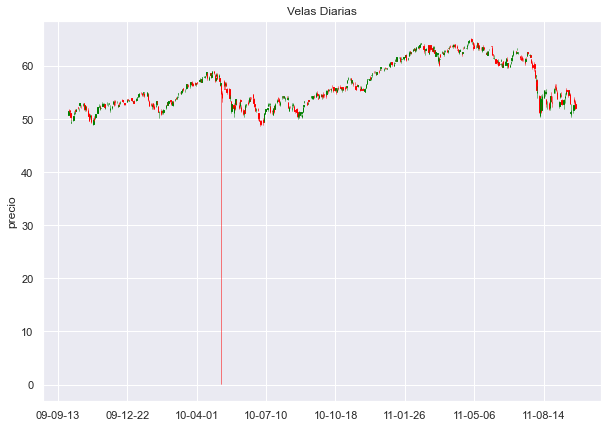

In [63]:
utils.plot_candle(velas_diarias_ohlcv,
                  width=.5,
                  figsize=(10, 7),
                  tick_formater='%y-%m-%d')

plt.title("Velas Diarias")
plt.ylabel('precio')
plt.show()

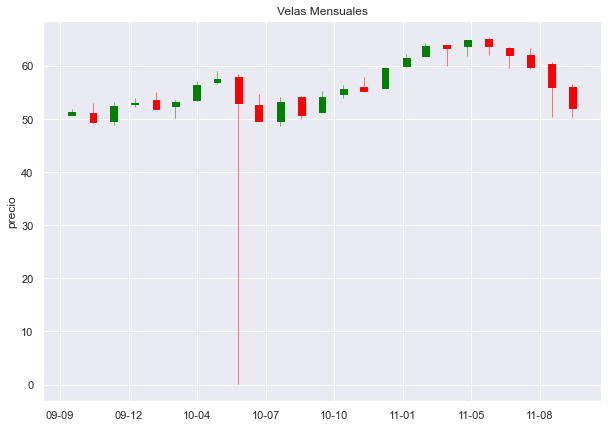

In [64]:
utils.plot_candle(velas_mensuales_ohlcv,
                  width=10,
                  figsize=(10, 7),
                  tick_formater='%y-%m')

plt.title("Velas Mensuales")
plt.ylabel('precio')
plt.show()

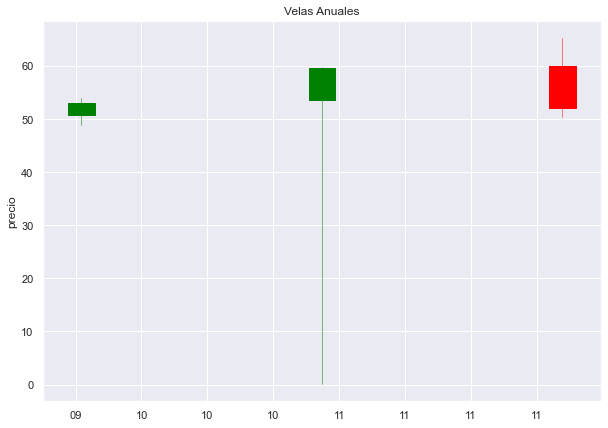

In [65]:
utils.plot_candle(velas_anuales_ohlcv,
                  width=40,
                  figsize=(10, 7),
                  tick_formater='%y')

plt.title("Velas Anuales")
plt.ylabel('precio')
plt.show()

**Alternativa 2**

C:\Users\Carlos\anaconda3\lib\site-packages\mplfinance\_arg_validators.py:35: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


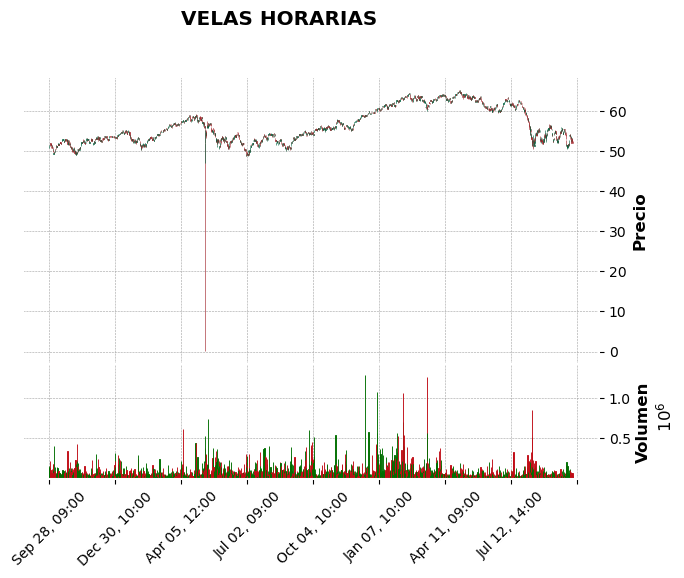

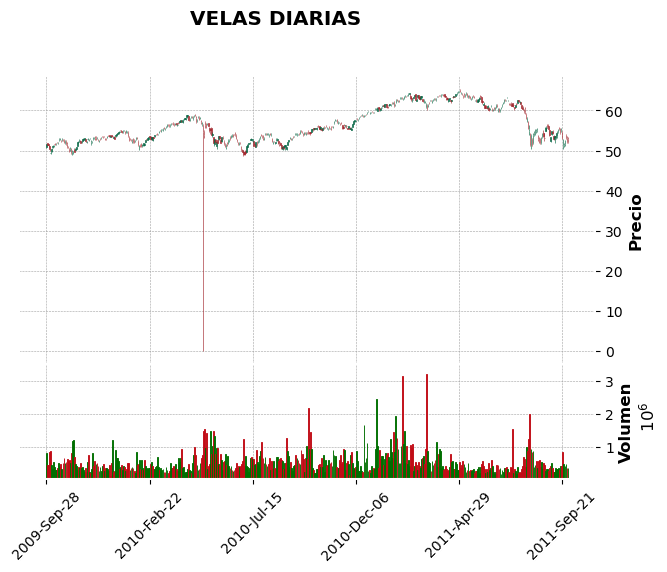

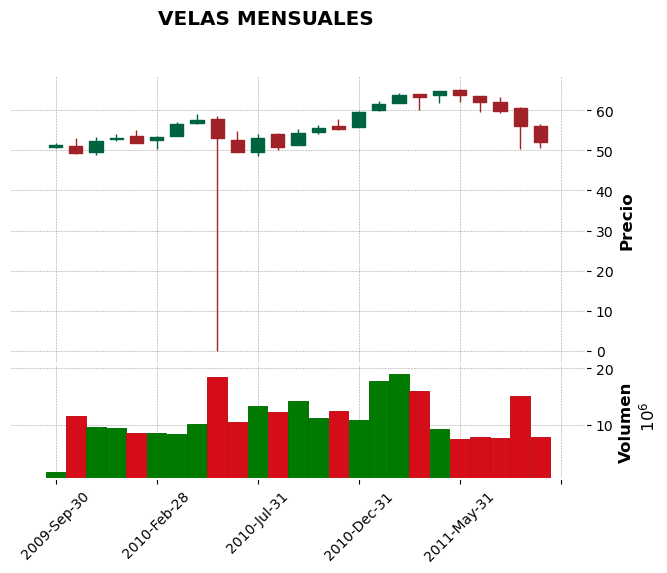

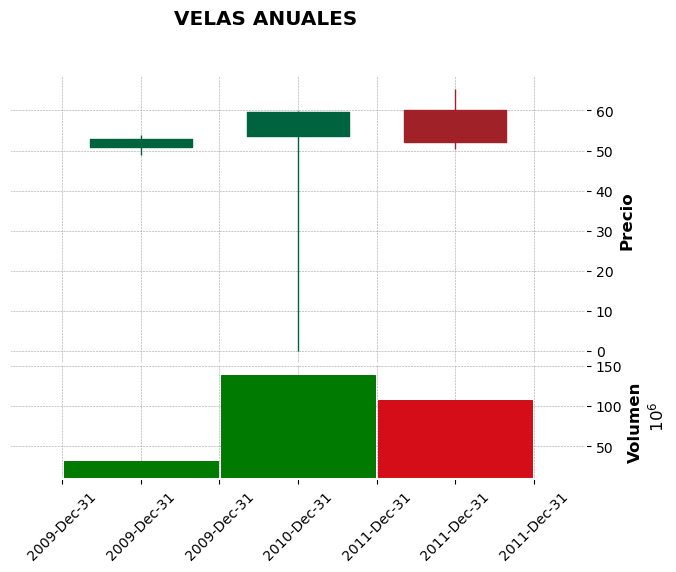

In [66]:
fplt.plot(
            velas_horarias_ohlcv,
            type='candle',
            style='charles',
            title='VELAS HORARIAS',
            ylabel='Precio',
            volume=True,
            ylabel_lower='Volumen',
            )

fplt.plot(
            velas_diarias_ohlcv,
            type='candle',
            style='charles',
            title='VELAS DIARIAS',
            ylabel='Precio',
            volume=True,
            ylabel_lower='Volumen',
            )

fplt.plot(
            velas_mensuales_ohlcv,
            type='candle',
            style='charles',
            title='VELAS MENSUALES',
            ylabel='Precio',
            volume=True,
            ylabel_lower='Volumen',
            )

fplt.plot(
            velas_anuales_ohlcv,
            type='candle',
            style='charles',
            title='VELAS ANUALES',
            ylabel='Precio',
            volume=True,
            ylabel_lower='Volumen',
            )

**4) Haz una función que muestre el precio cada vez que se produce una determinada
cantidad de negociaciones, pasada por parámetro. Estas son las denominadas ticks
bars. Prueba la función con 10000 negociaciones. Realiza una figura.**

Creo una función que me calcule las tickbars, para ello sólamente es necesario pasarle un parámetro, que serán el número de negociaciones:

In [67]:
def tick_bar(negociaciones):
    '''Esta función sirve para calcular las tick_bars'''
    precios = df_etf.price[::negociaciones]
    return(precios)

Ejecuto la función:

In [68]:
tickbar = tick_bar(10000)
tickbar

2009-09-28 09:30:00    50.7900
2009-10-01 15:08:32    50.0500
2009-10-08 09:38:00    51.7000
2009-10-15 15:14:41    52.9448
2009-10-22 09:29:16    51.9200
                        ...   
2011-08-18 14:01:38    52.5500
2011-08-24 15:57:08    54.2500
2011-09-01 10:00:51    56.4600
2011-09-13 14:10:51    53.6200
2011-09-22 12:27:39    51.1300
Name: price, Length: 100, dtype: float64

Graficamos:

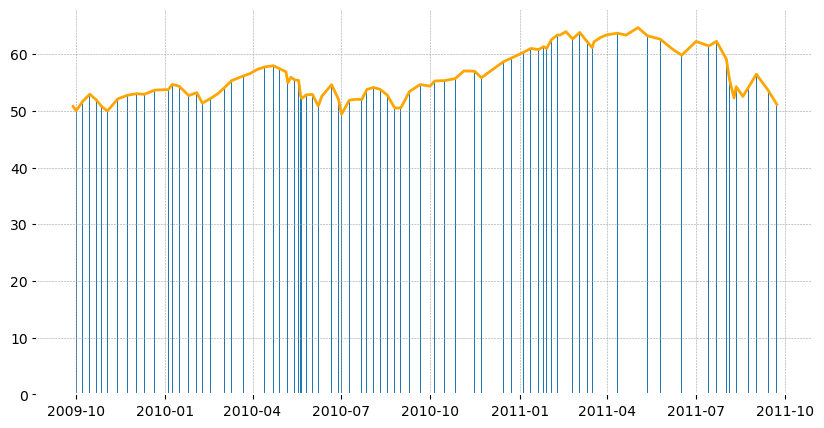

In [69]:
fig = plt.figure(figsize=(10,5))
plt.bar(tickbar.index, tickbar)
plt.plot(tickbar.index, tickbar, color="orange")
plt.show()

**5) Haz una función que muestre el precio cada vez que se negocia una determinada
cantidad de dólares, pasada por parámetro. Estas son las denominadas dollar
bars.Prueba la función con 100.000 dólares. Realiza una figura.**

Genero un data-frame con la cantidad de dólares negociados:

In [70]:
dolares_negociados = pd.DataFrame(df_etf['price'] * df_etf['size'])
dolares_negociados = dolares_negociados.set_axis(["volumen"], axis=1)

Creo una función que se va a encargar de darme el precio cada X (parámetro) dólares negociados. Como existen momentos en los que en una misma negociación se supera el límite de los 100.000 dólares, nos quedamos con la cantidad sobrante de dólares, y vuelve a sumar sobra esa cantidad hasta llegar a los 100.000 dólares de nuevo.

In [71]:
def cumsum_reset(cantidad):
    '''La función se encarga de darnos las dollar bars'''
    total = 0
    lista_precios = list()
    fechas = list()
    for posicion, fecha in enumerate(dolares_negociados.index):
        total += dolares_negociados.iloc[posicion]['volumen']
        if total >= cantidad:
            total = total - cantidad
            lista_precios.append(df_etf.iloc[posicion]['price'])
            fechas.append(df_etf.index[posicion])

    lista_precios = pd.DataFrame(lista_precios)
    fechas = pd.DataFrame(fechas)
    lista_precios = lista_precios.set_index(fechas[0])
    return(lista_precios)


Ejecutamos la función:

In [72]:
dollar_bar = cumsum_reset(100000)

In [73]:
dollar_bar

,0
0,
2009-09-28 09:31:50,50.7500
2009-09-28 09:33:02,50.8100
2009-09-28 09:33:54,50.8200
2009-09-28 09:37:33,50.8299
2009-09-28 09:41:33,50.8000
...,...
2011-09-29 15:21:27,52.0000
2011-09-29 15:22:12,52.0600
2011-09-29 15:23:22,52.0900


Graficamos las dollar_bar:

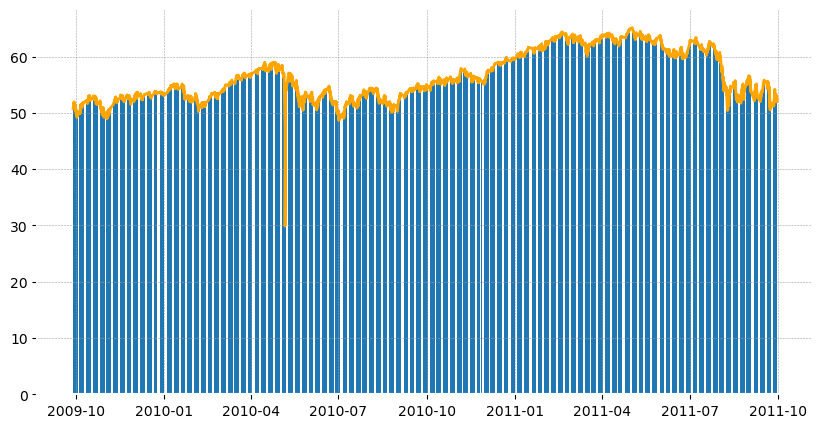

In [74]:
fig = plt.figure(figsize=(10,5))
plt.bar(dollar_bar.index, dollar_bar[0])
plt.plot(dollar_bar.index, dollar_bar[0], color="orange")
plt.show()

**6) Calcula los retornos diarios en el caso de las velas diarias, los retornos cada
10.000 negociaciones y los retornos cada 1.000.000$ negociados.**

Calculamos los retornos de las velas diarias:

In [75]:
retornos_diarios = (np.log(velas_diarias_ohlcv['close']).diff().dropna())
retornos_diarios 

2009-09-29   -0.000971
2009-09-30   -0.003892
2009-10-01   -0.019161
2009-10-02   -0.016160
2009-10-05    0.019676
                ...   
2011-09-23    0.004279
2011-09-26    0.021886
2011-09-27    0.010202
2011-09-28   -0.021661
2011-09-29    0.001727
Name: close, Length: 506, dtype: float64

Calculamos los retornos cada 10.000 negociaciones:

In [76]:
retornos_cada_10000 = (np.log(tickbar).diff().dropna())
retornos_cada_10000

2009-10-01 15:08:32   -0.014677
2009-10-08 09:38:00    0.032435
2009-10-15 15:14:41    0.023792
2009-10-22 09:29:16   -0.019546
2009-10-27 15:07:11   -0.021808
                         ...   
2011-08-18 14:01:38   -0.032206
2011-08-24 15:57:08    0.031838
2011-09-01 10:00:51    0.039929
2011-09-13 14:10:51   -0.051610
2011-09-22 12:27:39   -0.047551
Name: price, Length: 99, dtype: float64

Calculamos los retornos cada millón de dólares negociados:

In [77]:
precio_cada_1M = cumsum_reset(1000000)
retornos_cada_1M = np.log(precio_cada_1M).diff().dropna()
retornos_cada_1M

,0
0,
2009-09-28 09:52:47,0.001174
2009-09-28 09:54:36,-0.000020
2009-09-28 09:54:43,0.000215
2009-09-28 10:01:06,0.002324
2009-09-28 10:02:52,-0.000176
...,...
2011-09-29 14:14:23,-0.007274
2011-09-29 14:34:51,0.002878
2011-09-29 14:44:13,0.000575


**7) Haz una figura que compare la distribución de los tres retornos. ¿Qué diferencias
observas?**

In [78]:
retornos_cada_10000.describe()

count    99.000000
mean      0.000067
std       0.025305
min      -0.062636
25%      -0.015275
50%       0.003773
75%       0.016692
max       0.055992
Name: price, dtype: float64

In [79]:
retornos_cada_1M.describe()

,0
count,15781.000000
mean,0.000001
std,0.004500
min,-0.388619
25%,-0.000733
50%,0.000000
75%,0.000761
max,0.293078


In [80]:
retornos_diarios.describe()

count    506.000000
mean       0.000023
std        0.012907
min       -0.075596
25%       -0.005626
50%        0.000915
75%        0.006653
max        0.050904
Name: close, dtype: float64

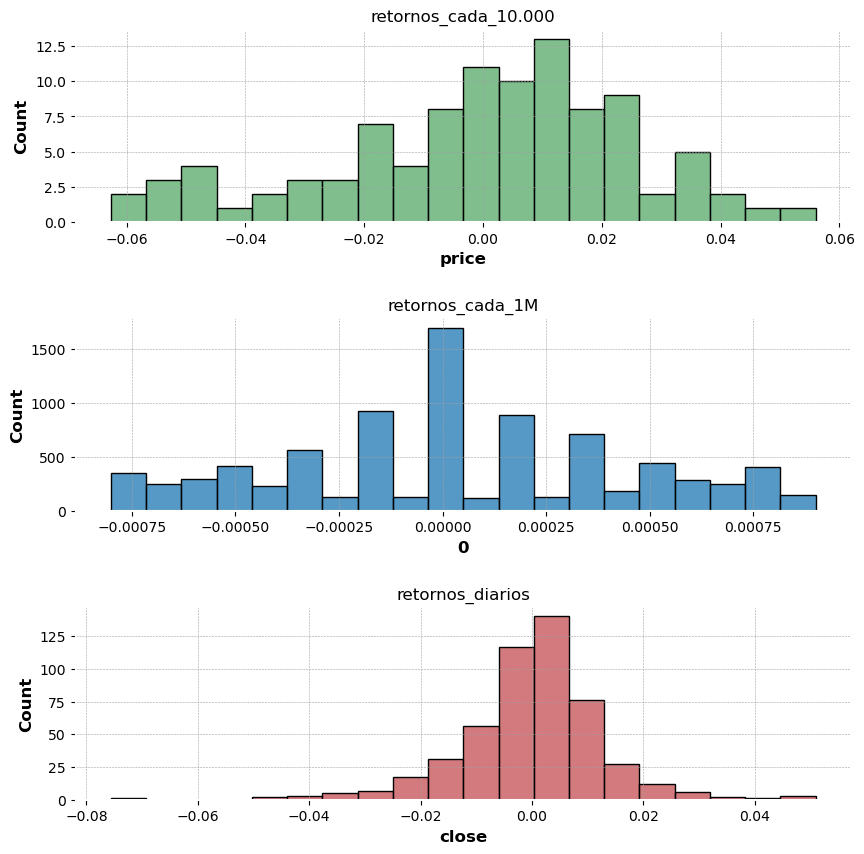

In [81]:
fig, axs = plt.subplots(nrows=3, figsize=(10,10))
plt.subplots_adjust(hspace=0.5)

sns.histplot(ax=axs[0],
            x=retornos_cada_10000, 
            color="g", 
            bins=20)
axs[0].set_title("retornos_cada_10.000")

sns.histplot(ax=axs[1],
            x=retornos_cada_1M[0],
            label="retornos_cada_1M",
            binrange=(-0.0008, 0.0009),
            bins=20)

axs[1].set_title("retornos_cada_1M")

sns.histplot(ax=axs[2],
            x=retornos_diarios,
            label="retornos_diarios",
            color="r",
            bins=20)
axs[2].set_title("retornos_diarios")
plt.show()

En cuanto a las diferencias que observamos entre los tres gráficos, todos presentan una cierta concentración respecto a su media con la existencia de outliers, los cuales son bastante más pronunciados en los retornos de cada 10.000 negociaciones. Habiéndo hecho un análisis con describe, también podemos observar que las distribuciones se mueven en el rango de dos desviaciones típicas respecto a su media.

#### **Ejercicio 4 - TRIPLE BARRIER METHOD**
En este ejercicio vamos a practicar el tratamiento de series temporales financieras. Para
ello usaremos datos tick a tick de un ETF del IVE (S&P 500 Value Index).
Calcularemos muestreos sobre estos datos tick a tick que son muy comunes en finanzas,
en concreto desarrollaremos las llamadas ticks bars y dollar bars. Si estas interesado en
conocer más detalles sobre esto puedes consultar [2].
Los datos los obtendremos de http://www.kibot.com/free_historical_data.aspx,
disponibles en el apartado \free tick intraday data" subapartado IVE: \Tick with bid ask
data".
Realiza los siguientes apartados:

**1) Usando las dollar bars calculadas en el apartado anterior. Programa una función
que calcule para cada muestra una etiqueta, que tendrá valor 0, 1 o -1. Estos valores
están determinados dependiendo de que barrera se toque antes: 0 para la barrera
vertical, 1 para la horizontal superior y -1 para la inferior. Puedes ver dos ejemplos
en la Figura 4. La distancia en porcentaje a las barreras verticales y el número de
muestras a la barrera horizontal son parámetros de la función.**

Para llevar a cabo este ejercicio voy a utilizar las dollar bar de un millón de dólares negociados, aunque estará flexibilizado para hacerlo con cualquier cantidad. Para ello, primero vamos a definir nuestra función encargada de etiquetar la muestra.

In [82]:
def labelling(df, tiempo, porcentaje):
    
    '''Esta función se encargará de poner etiquetas
    a nuestras dollar bars, deberemos pasarle como 
    parámetro el data-frame de las bars, una ventana
    temporal, y el porcentaje para delimitar las barras
    horizontales superior e inferior.'''
    
    label = list()
    fecha = list()

    for posicion in np.arange(0, len(df)):

        inicio = df.iloc[posicion][0]
        barrera_superior = inicio * (1 + porcentaje)
        barrera_inferior = inicio * (1 - porcentaje)
        rango = (df.iloc[(posicion + 1):(posicion + 1 + tiempo)][0]).tolist()

        if len(rango) < tiempo:
            label.append("NULL")
            fecha.append(df.index[posicion])
        else:

            if (rango >= barrera_superior).any() == False and (
                    rango <= barrera_inferior).any() == False:
                # La serie sale por el final, no ha tocado ninguna de las dos
                # barras.
                label.append(0)
                fecha.append(df.index[posicion])
            else:
                rango = np.array(rango)
                if (rango >= barrera_superior).any() and (
                        rango <= barrera_inferior).any() == False:
                    label.append(1)
                    fecha.append(df.index[posicion])
                elif (rango >= barrera_superior).any() == False and (rango <= barrera_inferior).any() == True:
                    label.append(-1)
                    fecha.append(df.index[posicion])
                elif np.min(np.where(rango >= barrera_superior)) < np.min(np.where(rango <= barrera_inferior)):
                    label.append(1)
                    fecha.append(df.index[posicion])
                else:
                    label.append(-1)
                    fecha.append(df.index[posicion])

    label = pd.DataFrame(label, index=fecha)
    dbar_etiquetas = pd.concat([df, label], ignore_index=True, axis=1)
    dbar_etiquetas = dbar_etiquetas.set_axis(["precio", "label"], axis=1)
    dbar_etiquetas = dbar_etiquetas[dbar_etiquetas != "NULL"]
    dbar_etiquetas = dbar_etiquetas.dropna()

    return(dbar_etiquetas)

Ahora vamos a pasarle las dollar bars de un millón para que ejecute la función. En este caso, usaremos una ventana temporal de 10 días y un 0.1% para las barreras horizontales.

In [83]:
dollar_bar = precio_cada_1M
dollarbar_labelled = labelling(dollar_bar, 10, 0.001)
dollarbar_labelled

,precio,label
2009-09-28 09:46:34,51.070,1
2009-09-28 09:52:47,51.130,1
2009-09-28 09:54:36,51.129,1
2009-09-28 09:54:43,51.140,1
2009-09-28 10:01:06,51.259,1
...,...,...
2011-09-29 10:04:54,53.080,-1
2011-09-29 10:32:53,52.770,1
2011-09-29 10:59:20,52.750,1
2011-09-29 11:30:35,52.850,1


Vemos el porcentaje de etiquetas como ha quedado:

In [85]:
etiquetas = dollarbar_labelled["label"].value_counts()
total = dollarbar_labelled["label"].value_counts().sum()
porcentajes = etiquetas / total
porcentajes*100

 1    49.137712
-1    44.274664
 0     6.587624
Name: label, dtype: float64

**2) Realiza una estudio de la distancia en porcentaje a las barreras verticales y el
número de muestras a la horizontal. Busca la manera de que obtengas el número de
etiquetas de cada clase (0, -1 y 1) lo más balanceada posible.**

Para este ejercicio vamos a usar la librería multiprocessing, ya que de este modo vamos a mejorar notablemente la eficiencia de nuestro código. Del mismo modo que con las bandas de bollinger, vamos a importar una función desde el módulo funciones_multiprocessing, y le vamos a pasar un parametro con itertools llamado "all combinations". Este parámetro constará de un rango de ventanas temporales, porcentajes, y el data-frame de dollar-bars. La idea es llevar a cabo una simulación de 200 escenarios para encontrar la clase mejor balanceada.

In [86]:
tiempo = (np.arange(1, 21)).tolist()
porcentaje = ((np.arange(1, 11))/1000).tolist()
df_list = [dollar_bar]
print("Rango temporal:", tiempo)
print("Porcentajes:", porcentaje)

Rango temporal: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Porcentajes: [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01]


Pasamos las listas por itertools.product y determinamos el número de núcleos de la cpu a utilizar, ejecutamos la función con la librería multiprocessing usando starmap, y la guardamos en una variable. El resultado va a ser 200 simulaciones en formato lista de tuplas en las que nos vamos a encontrar, para cada simulación: 1) Un data-frame de las dollar-bars con las etiquetas para cada simulación, 2) La ventana temporal utilizada, y 3) El porcentaje usado para las barras horizontales.

In [87]:
all_combinations = itertools.product(df_list, tiempo, porcentaje)
pool = mp.Pool(mp.cpu_count()-2)
if __name__ == "__main__":
    labelled = pool.starmap(
        funciones_multiprocessing.labelling, all_combinations)

In [88]:
labelled[0:4]

[(                     precio label
  2009-09-28 09:46:34  51.070     1
  2009-09-28 09:52:47  51.130     0
  2009-09-28 09:54:36  51.129     0
  2009-09-28 09:54:43  51.140     1
  2009-09-28 10:01:06  51.259     0
  ...                     ...   ...
  2011-09-29 13:47:55  52.430    -1
  2011-09-29 14:14:23  52.050     1
  2011-09-29 14:34:51  52.200     0
  2011-09-29 14:44:13  52.230    -1
  2011-09-29 14:57:17  52.170    -1
  
  [15781 rows x 2 columns],
  1,
  0.001),
 (                     precio label
  2009-09-28 09:46:34  51.070     0
  2009-09-28 09:52:47  51.130     0
  2009-09-28 09:54:36  51.129     0
  2009-09-28 09:54:43  51.140     1
  2009-09-28 10:01:06  51.259     0
  ...                     ...   ...
  2011-09-29 13:47:55  52.430    -1
  2011-09-29 14:14:23  52.050     1
  2011-09-29 14:34:51  52.200     0
  2011-09-29 14:44:13  52.230     0
  2011-09-29 14:57:17  52.170     0
  
  [15781 rows x 2 columns],
  1,
  0.002),
 (                     precio label
  2009-0

Una vez tenemos las simulaciones, simplemente deberemos calcular los porcentajes de cada etiqueta dentro de cada simulación, y quedarnos con aquella simulación que tenga la clase mejor balanceada.

In [89]:
diferencias_anteriores = 1

for item in np.arange(0, len(labelled)):

    etiquetas = labelled[item][0]["label"].value_counts()
    total = labelled[item][0]["label"].value_counts().sum()
    porcentajes = etiquetas / total
    ordered = np.sort(porcentajes)
    diferencia = (
        ordered[2] - ordered[1]) + (ordered[2] - ordered[0]) + (ordered[1] - ordered[0])

    if diferencia < diferencias_anteriores:
        diferencias_anteriores = diferencia
        mejor_balanceada = labelled[item]
        etiqueta = mejor_balanceada[0]["label"].value_counts()
        totales = mejor_balanceada[0]["label"].value_counts().sum()
        porcentajes_fin = etiquetas / total

In [90]:
print(f'''Partiendo de una simulación de 200 escenarios, la clase mejor balanceada se consigue usando una ventana de {mejor_balanceada[1]} días, 
y aplicando un porcentaje del {mejor_balanceada[2]*100}%. 
De esta forma, se obtiene el siguiente resultado: 
{(porcentajes_fin)*100}''')

Partiendo de una simulación de 200 escenarios, la clase mejor balanceada se consigue usando una ventana de 19 días, 
y aplicando un porcentaje del 0.5%. 
De esta forma, se obtiene el siguiente resultado: 
 1    33.667449
 0    33.629385
-1    32.703166
Name: label, dtype: float64
